In [1]:
%matplotlib inline
from utils import *

import pywt
from itertools import chain
from scipy import stats, signal


from sklearn import*
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [55]:
data = load_data(database_name)

In [2]:
class DATA(object):    
    # ---------------------------------------------------------------------------------------------------   
    def __init__(self, database_name, target, features, records_numbers=None):  
        self.data = list()
        self.X = list()
        self.Y = list()

        if records_numbers is None:
            folder_path = os.path.dirname( get_dataset_file_path(database_name,'') )
            file_path_list = list(Path(folder_path).glob('*.pkl'))     
        else:
            file_path_list = [get_dataset_file_path(database_name, 'record_'+"{0:0=2d}".format(n)) for n in records_numbers]
            
        for file_path in file_path_list:
            df = pd.read_pickle( file_path )
            for feature in features:
                x = df.filter(regex=features, axis=1).values
#             y = df.filter(regex=target, axis=1).values
            y = df.filter(regex=target, axis=1).values
            
            # lists
            self.data.append( df )
            self.X.append( x )
            self.Y.append( y.reshape((len(y))) )

        self.X = np.array(self.X)
        self.Y = np.array(self.Y)
        return           
    # ---------------------------------------------------------------------------------------------------   
    def segment(self, win_size=None, step=1, as_one=True):
        if step is None: step= win_size
        
        segmented_data = copy.deepcopy(self)
        for i,(x,y) in enumerate(zip(self.X, self.Y)):            
            segmented_data.X[i] = np.array([ x[i:i+win_size,:].flatten() for i in range(0, len(x)-win_size+1, step) ])
            segmented_data.Y[i] = np.array(y[win_size-1::step])
        
        if as_one:
            segmented_data.X = np.concatenate(segmented_data.X)
            segmented_data.Y = np.concatenate(segmented_data.Y)

        return segmented_data
    # ---------------------------------------------------------------------------------------------------
    def segment_feature(self, win_size=None, step=1, as_one=True):
        if step is None: step= win_size
        
        features = copy.deepcopy(self)
        for i,(x,y) in enumerate(zip(self.X, self.Y)):   
            features.Y[i] = np.array(y[win_size-1::step])
            features.X[i] = np.array([ np.array(get_features(x[i:i+win_size,:]).flatten()) for i in range(0, len(x)-win_size+1, step) ])            
        
        if as_one:
            features.X = np.concatenate(features.X)
            features.Y = np.concatenate(features.Y)

        return features
    # ---------------------------------------------------------------------------------------------------

##############################################################################################################
def get_features( x_t ):
    axis = 1
    x_f = np.real( np.fft.fft(x_t, axis=axis) )
    x_wA, x_wD = pywt.dwt(x_t, 'db1', axis=axis)
    dx_t = np.diff( x_t, axis=axis )
    
    features = list()
    for x_ in [x_t, x_f, x_wA, x_wD, dx_t]:     
        feature = list()  
        feature.append( np.mean( x_, axis=axis )) 
        feature.append( np.std( x_, axis=axis ))                               
        feature.append( np.median( x_, axis=axis ))               
        feature.append( np.min( x_, axis=axis ))               
        feature.append( np.max( x_, axis=axis ))               
        feature.append( np.var( x_, axis=axis ))               
        feature.append( np.percentile( x_, 25, axis=axis ))               
        feature.append( np.percentile( x_, 75, axis=axis ))               
        feature.append( stats.skew( x_, axis=axis))               
        feature.append( stats.kurtosis( x_, axis=axis))               
        feature.append( stats.iqr( x_, axis=axis))               
        feature.append( np.sqrt(np.mean(np.power(x_,2), axis=axis)))               
        
        feature = np.array(feature).transpose()
        features.append(feature)
        
    return np.concatenate(features, axis=1)
##############################################################################################################    

In [ ]:
class DATA(object):
    
    def __init__(self, dataset_name, target, features):
        
        self.features_list = list()
        self.target_list = list()
        
        folder_path = os.path.dirname( get_dataset_file_path(dataset_name,'') )
        for file_path in list(Path(folder_path).glob('*.pkl')):        
            data = pd.read_pickle( file_path )   
            if type(features) is list:
                features_df_list, names = list(), list()
                for feature in features:
                    feature_df = data.filter(regex=feature, axis=1)
                    features_df_list.append(feature_df )
                    names = [*names, *feature_df.columns]
                features_df= pd.concat(features_df_list, axis=1, ignore_index=True)
                features_df.columns = names 
            else:
                features_df = data.filter(regex=features, axis=1)
            target_df = data.filter(regex=target, axis=1).rename({target:'target'}, axis=1)
            
            self.features_list.append( features_df )
            self.target_list.append( target_df)                
        return
     
    
    
    def get_data(self, idxs_list=None, win_size=None, step=None):        
        if idxs_list is None: idxs_list = np.arange(len(self.features_list))  
        if win_size is not None:
            if step is None: step = win_size
#             elif type(step) is float: step = max(1, int(step * win_size))

        dataset_df = pd.DataFrame()     
        for idx in idxs_list:  
            features_df, target_df = self.features_list[idx], self.target_list[idx]
            if win_size is not None: features_df, target_df = segment(features_df, target_df, win_size, step)
            
            dataset_df = dataset_df.append( pd.concat([ target_df, features_df], axis=1), ignore_index=True )
        dataset_df.astype('float64').dtypes
        return dataset_df
 

  
def segment(features_df, target_df, win_size, step):
    
    features_df_segmented = pd.DataFrame()
    target_df_segmented = pd.DataFrame()

    for i in range(0, len(features_df)- win_size, step):
        target_df_segmented = target_df_segmented.append(target_df.loc[i+win_size-1], ignore_index=True)

        row = dict()
        for feature_name in features_df.columns: 
            for j in range(win_size): row.update({ feature_name + "{0:0=2d}".format(j): features_df.loc[i+j, feature_name] })        
        features_df_segmented = features_df_segmented.append(row, ignore_index=True)

    return features_df_segmented, target_df_segmented

#### Load Data

In [4]:
target = 'distance_0' 
features = ['rssi','status']

train_data = DATA('dataset_02', target, features)
validation_data = DATA('dataset_03', target, features)

print( "Train Data - X: \t", np.shape(train_data.X), np.shape(train_data.X[0]))
print( "Train Data - Y: \t", np.shape(train_data.Y), np.shape(train_data.Y[0]))
print( "Validation Data - X: \t", np.shape(validation_data.X), np.shape(validation_data.X[0]))
print( "Validation Data - Y: \t", np.shape(validation_data.Y), np.shape(validation_data.Y[0]))

TypeError: unhashable type: 'list'

#### Window Sliding and Feature Extraction

In [46]:
win_size = 10
step = 1

train_data_segmented = train_data.segment(win_size, step)
train_data_segmented_f = train_data.segment_feature(win_size, step)

validation_data_segmented = validation_data.segment(win_size, step, as_one=False)
validation_data_segmented_f = validation_data.segment_feature(win_size, step, as_one=False)

# sklearn

In [47]:
model = GradientBoostingRegressor(random_state=0)
model.fit( train_data_segmented_f.X, train_data_segmented_f.Y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

NRMSE= 1.73 %
NRMSE_smoothed= 1.71 %


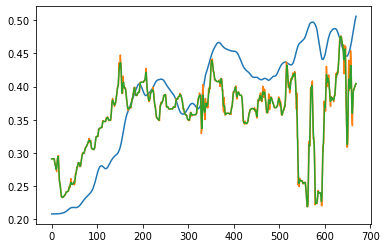

In [27]:
idx = 6
data = validation_data_segmented_f

x_test, y_test, data_test = data.X[idx], data.Y[idx], data.data[idx]

preds = model.predict(x_test)
preds_smooth = signal.savgol_filter( preds, window_length=3, polyorder=1)            

# r2 = model.score(train_data_segmented.X, train_data_segmented.Y)
print('NRMSE=', np.round(mean_squared_error( y_test, preds ) / np.mean(y_test) * 100, 2), '%' )
print('NRMSE_smoothed=', np.round(mean_squared_error( y_test, preds_smooth ) / np.mean(y_test) * 100, 2), '%' )

plt.plot(validation_data_segmented.Y[idx])
plt.plot(preds)
plt.plot(preds_smooth)
plt.show()

# plt.subplot(311)
# plt.plot(preds)
# plt.plot(preds_smooth)
# plt.plot(data_test.distance_0.values)
# plt.plot(data_test.distance_1.values)

# plt.subplot(312)
# plt.plot(data_test.misalignment_0.values)
# plt.plot(data_test.misalignment_1.values)

# plt.subplot(313)
# plt.plot(data_test.rssi_0.values)
# plt.plot(data_test.rssi_1.values)


In [35]:
for window_length in [3, 5, 7, 9, 11, 13, 15]:
    preds_smooth = signal.savgol_filter( preds, window_length=window_length, polyorder=1)            
    error = abs(y_test-preds_smooth)*100
#     plt.plot(error)
#     plt.show()
    print(np.median(error))

5.162614937906773
5.243974248098651
5.2323825186161965
5.216917182085323
5.2002125056589605
5.148156726836123
5.0239344350472805


In [18]:
model2 = GradientBoostingRegressor(random_state=0)
model2.fit( train_data_segmented.X, train_data_segmented.Y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

NRMSE= 1.08 %
NRMSE_smoothed= 1.04 %


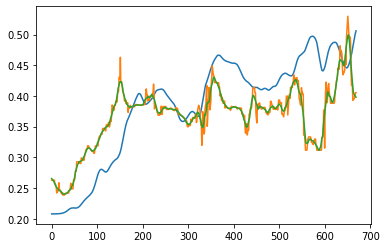

In [19]:
idx = 6
data = validation_data_segmented

x_test, y_test, data_test = data.X[idx], data.Y[idx], data.data[idx]

preds = model2.predict(x_test)
preds_smooth = signal.savgol_filter( preds, window_length=11, polyorder=1)            

# r2 = model.score(train_data_segmented.X, train_data_segmented.Y)
print('NRMSE=', np.round(mean_squared_error( y_test, preds ) / np.mean(y_test) * 100, 2), '%' )
print('NRMSE_smoothed=', np.round(mean_squared_error( y_test, preds_smooth ) / np.mean(y_test) * 100, 2), '%' )


plt.plot(validation_data_segmented.Y[idx])
plt.plot(preds)
plt.plot(preds_smooth)
plt.show()

# plt.subplot(311)
# plt.plot(preds)
# plt.plot(preds_smooth)
# plt.plot(data_test.distance_0.values)
# plt.plot(data_test.distance_1.values)

# plt.subplot(312)
# plt.plot(data_test.misalignment_0.values)
# plt.plot(data_test.misalignment_1.values)

# plt.subplot(313)
# plt.plot(data_test.rssi_0.values)
# plt.plot(data_test.rssi_1.values)


In [ ]:
# model = make_pipeline(StandardScaler(), model)
